<a href="https://colab.research.google.com/github/LugenderGeist/computer_vision_2/blob/main/comp_vision_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №2

- Взять 2 изображения со сдвигом
- Подготовить изображения
- Определить на каждой фотографии ключевые точки
- Отфильтровать самые наилучшие
- Построить по каждой точке дескриптор (можете использовать любой, рекомендуется SIFT)
- Сопоставить два соседних изображения на предмет соответствия ключевых точек
- Построить траекторию движения камеры

Подключаем библиотеки и гугл диск:

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


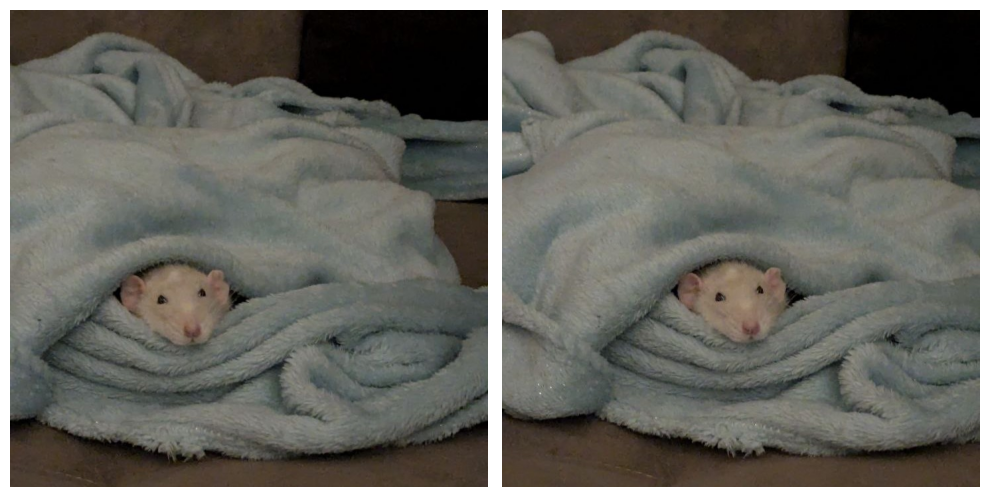

In [ ]:
# импортируем библиотеки
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# подключаем гугл диск
from google.colab import drive
drive.mount('/content/drive')

img_1 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/computer_vision/12.jpg', 1)
img_2 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/computer_vision/13.jpg', 1)

# Инвертируем BGR в RGB
img_1 = img_1[:, :, ::-1]
img_2 = img_2[:, :, ::-1]

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.imshow(img_1)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_2)
plt.axis('off')

plt.tight_layout()
plt.show()

## Перевод в grayscsale

Возьмем два изображения, сделанные со сдвигом камеры. Переведем их в grayscale.

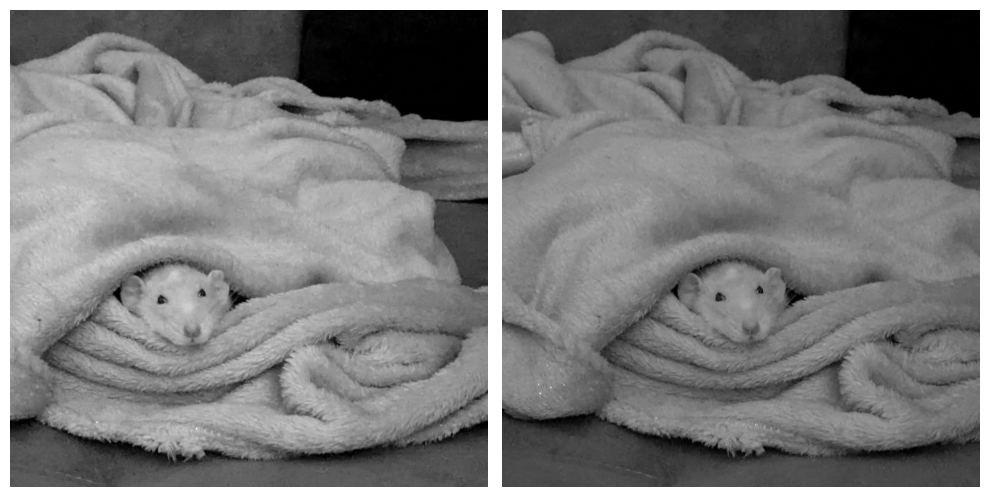

In [ ]:
# Разбиваем изображение на каналы
red_channel_1 = img_1[:, :, 0].astype(np.float32)
green_channel_1 = img_1[:, :, 1].astype(np.float32)
blue_channel_1 = img_1[:, :, 2].astype(np.float32)

red_channel_2 = img_2[:, :, 0].astype(np.float32)
green_channel_2 = img_2[:, :, 1].astype(np.float32)
blue_channel_2 = img_2[:, :, 2].astype(np.float32)

# Применяем формулу для преобразования в grayscale
grayscale_1 = 0.299 * red_channel_1 + 0.587 * green_channel_1 + 0.114 * blue_channel_1
grayscale_2 = 0.299 * red_channel_2 + 0.587 * green_channel_2 + 0.114 * blue_channel_2

# Преобразуем результат обратно в uint8
img_1 = np.clip(grayscale_1, 0, 255).astype(np.uint8)
img_2 = np.clip(grayscale_2, 0, 255).astype(np.uint8)

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.imshow(img_1)
plt.imshow(img_1, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_2)
plt.imshow(img_2, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

## Выравнивание яркости

Дескриптор ключевой точки (keypoint descriptor) — это числовое представление окрестности ключевой точки, которое описывает её уникальные характеристики.  
Разная яркость изображений может повлиять на формирование дескриптора, а при сопоставлении изображений многие алгоритмы опираются на сравнение дескрипторов ключевых точек.

Для выравнивания яркости будем использовать метод линейной трансформации яркости и выровняем яркость второго изображения относительно первого.  


Первое изображение:
  Среднее: 86.36
  Стандартное отклонение: 37.63
Исходное второе изображение:
  Среднее: 92.92
  Стандартное отклонение: 35.26
Нормализованное второе изображение:
  Среднее: 87.62
  Стандартное отклонение: 34.59


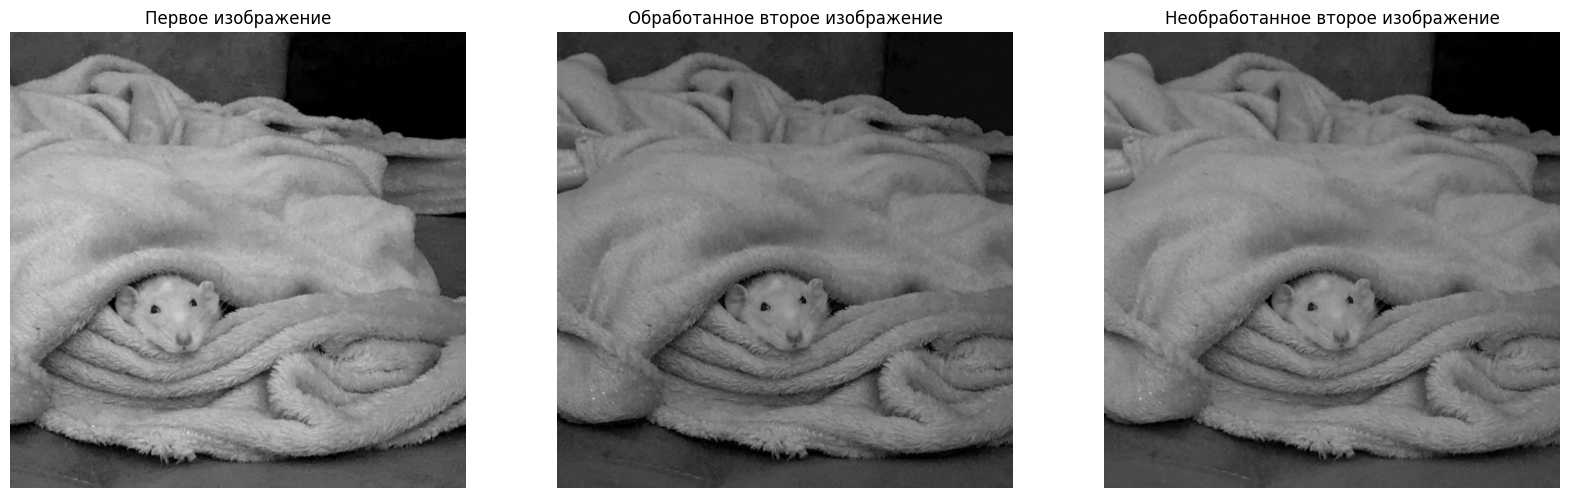

In [ ]:
def normalize_brightness(img_1, img_2):
    # Вычисляем среднее и стандартное отклонение для обоих изображений
    mean1, std1 = cv2.meanStdDev(img_1)
    mean2, std2 = cv2.meanStdDev(img_2)

    # Преобразуем значения в скаляры
    mean1 = mean1[0][0]
    std1 = std1[0][0]
    mean2 = mean2[0][0]
    std2 = std2[0][0]

    # Вычисляем коэффициенты преобразования
    alpha = std1 / std2
    beta = mean1 - mean2 * alpha

    # Применяем преобразование
    normalized = cv2.convertScaleAbs(img_2, alpha=alpha, beta=beta)

    # Ограничиваем значения пикселей [0, 255]
    normalized = np.clip(normalized, 0, 255).astype(np.uint8)

    return normalized

# Приведение к одинаковым размерам
if img_1.shape != img_2.shape:
    img_2 = cv2.resize(img_2, (img_1.shape[1], img_1.shape[0]))

# Нормализация второго изображения
img_2_light = normalize_brightness(img_1, img_2)

# Вывод статистики
def print_stats(img, name):
    mean, std = cv2.meanStdDev(img)
    print(f"{name}:")
    print(f"  Среднее: {mean[0][0]:.2f}")
    print(f"  Стандартное отклонение: {std[0][0]:.2f}")

print_stats(img_1, "Первое изображение")
print_stats(img_2, "Исходное второе изображение")
print_stats(img_2_light, "Нормализованное второе изображение")

# Отображение результатов
plt.figure(figsize=(20, 15))

plt.subplot(1, 3, 1)
plt.title("Первое изображение")
plt.imshow(img_1, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Обработанное второе изображение")
plt.imshow(img_2_light, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Необработанное второе изображение")
plt.imshow(img_2, cmap='gray')
plt.axis('off')

plt.show()

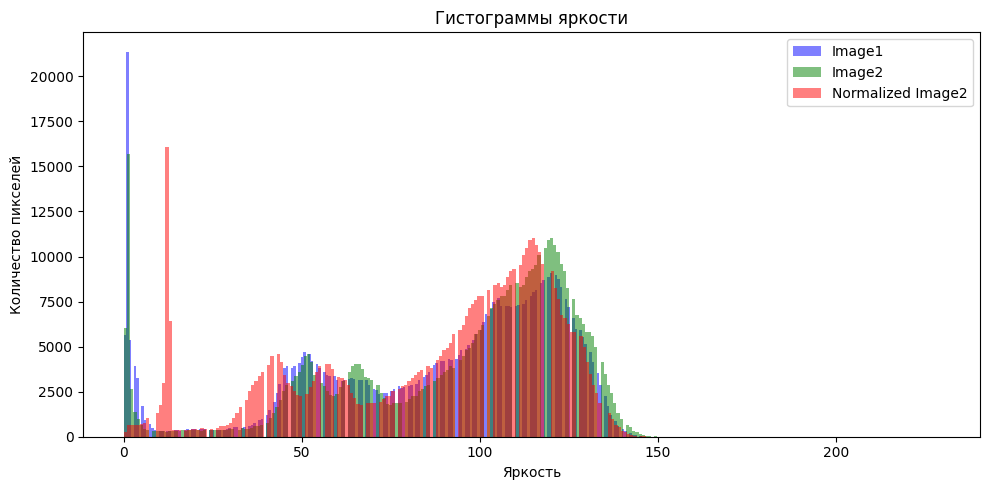

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Гистограммы яркости")
plt.hist(img_1.ravel(), bins=256, color='blue', alpha=0.5, label='Image1')
plt.hist(img_2.ravel(), bins=256, color='green', alpha=0.5, label='Image2')
plt.hist(img_2_light.ravel(), bins=256, color='red', alpha=0.5, label='Normalized Image2')
plt.legend()
plt.xlabel('Яркость')
plt.ylabel('Количество пикселей')

plt.tight_layout()
plt.show()

По гистограмме сложно сказать, что изображения стали ближе друг к другу по яркости. Однако, работа уже проделана, поэтому проверим, действительно ли такая обработка изображения в данном случае даст какой-то значимый результат при поиске общих ключевых точек.

## SIFT

SIFT (Scale-Invariant Feature Transform) — алгоритм обнаружения ключевых точек и вычисления их дескрипторов, работающий на основе генерации пирамиды масштабов: исходное изображение фильтруется с помощью гауссовых ядер с разными значениями параметра σ (стандартного отклонения). Так создается пирамида масштабов, где каждый слой представляет собой последовательность изображений, уменьшенных в два раза относительно предыдущей октавы.



Количество ключевых точек: 522 588 499
Размер дескриптора: (522, 128) (588, 128) (499, 128)


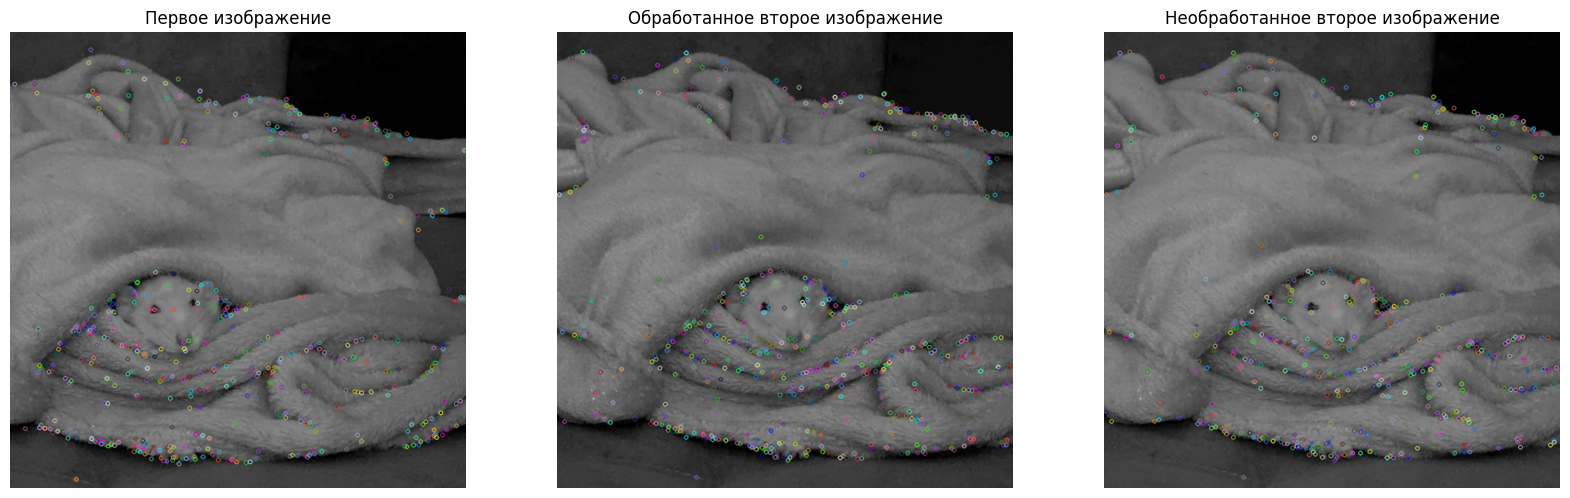

In [ ]:
sift = cv2.SIFT_create()

# Вычисление ключевых точек и дескрипторов
keypoints_1, descriptors_1 = sift.detectAndCompute(img_1, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img_2_light, None)
keypoints_old, descriptors_old = sift.detectAndCompute(img_2, None)

# Вывод информации о ключевых точках и дескрипторах
print(f"Количество ключевых точек: {len(keypoints_1)} {len(keypoints_2)} {len(keypoints_old)}")
print(f"Размер дескриптора: {descriptors_1.shape} {descriptors_2.shape} {descriptors_old.shape}")

# Визуализация ключевых точек на изображении
points_1 = cv2.drawKeypoints(img_1, keypoints_1, None)
points_2 = cv2.drawKeypoints(img_2_light, keypoints_2, None)
points_old = cv2.drawKeypoints(img_2, keypoints_old, None)

# Отображение результатов
plt.figure(figsize=(20, 15))

plt.subplot(1, 3, 1)
plt.title("Первое изображение")
plt.imshow(points_1, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Обработанное второе изображение")
plt.imshow(points_2, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Необработанное второе изображение")
plt.imshow(points_old, cmap='gray')
plt.axis('off')

plt.show()

На данном этапе можно увидеть, что на обработанном изображении ключевых точек больше и размер дескриптора больше. Количество ключевых точек, потенциально даст большую вероятность того, что найдется больше соответствий с первым изображением.

## Фильтрация точек

Полученные точки отфильтруем по критериям:
- response - разница между тем, какое значение по гауссовому распределению имела точка ранее, и какое значение она имеет на данном слое обработки. По сути, это то, насколько важной точка осталась при переходе с одного слоя на другой.
- size - размер области, которая описывает ключевую точку, определяющаяся слоем, на котором точка была обнаружена.

Количество ключевых точек в 1 изображении: 91
Количество ключевых точек во 2 изображении: 91
Количество ключевых точек в необработанном 2 изображении: 84


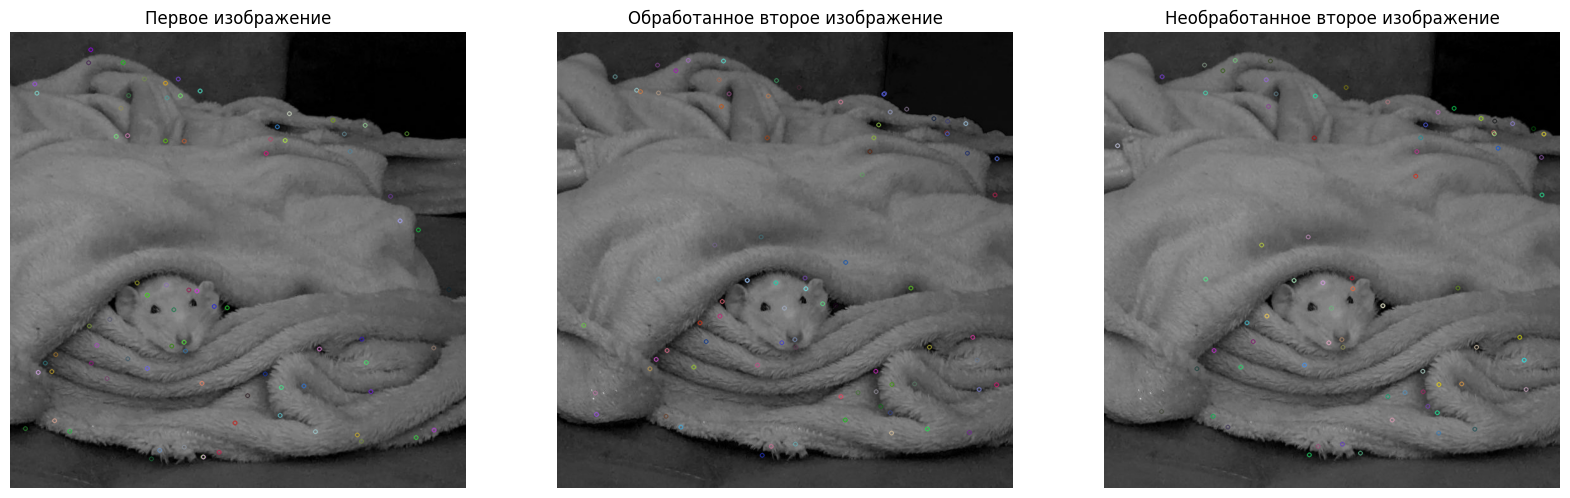

In [ ]:
filtered_keypoints_1 = []
filtered_keypoints_2 = []
filtered_keypoints_old = []

# Фильтрация ключевых точек (пример: оставить точки с size > 10 и response > 0.01)
filtered_keypoints_1 = [kp for kp in keypoints_1 if kp.size > 10 and kp.response > 0.01]
filtered_keypoints_2 = [kp for kp in keypoints_2 if kp.size > 10 and kp.response > 0.01]
filtered_keypoints_old = [kp for kp in keypoints_old if kp.size > 10 and kp.response > 0.01]

# Отбор соответствующих дескрипторов для отфильтрованных ключевых точек
filtered_descriptors_1 = np.array([descriptors_1[i] for i, kp in enumerate(keypoints_1) if kp in filtered_keypoints_1])
filtered_descriptors_2 = np.array([descriptors_2[i] for i, kp in enumerate(keypoints_2) if kp in filtered_keypoints_2])
filtered_descriptors_old = np.array([descriptors_old[i] for i, kp in enumerate(keypoints_old) if kp in filtered_keypoints_old])

# Вывод количества ключевых точек после фильтрации
print(f"Количество ключевых точек в 1 изображении: {len(filtered_keypoints_1)}")
print(f"Количество ключевых точек во 2 изображении: {len(filtered_keypoints_2)}")
print(f"Количество ключевых точек в необработанном 2 изображении: {len(filtered_keypoints_old)}")

# Отображение результатов
img_1_points = cv2.drawKeypoints(img_1, filtered_keypoints_1, None)
img_2_points = cv2.drawKeypoints(img_2_light, filtered_keypoints_2, None)
img_old_points = cv2.drawKeypoints(img_2, filtered_keypoints_old, None)

# Отображение результатов
plt.figure(figsize=(20, 15))

plt.subplot(1, 3, 1)
plt.title("Первое изображение")
plt.imshow(img_1_points, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Обработанное второе изображение")
plt.imshow(img_2_points, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Необработанное второе изображение")
plt.imshow(img_old_points, cmap='gray')
plt.axis('off')

plt.show()

После фильтрации количество ключевых точек на обработанном изображении все еще больше, что говорит о том, что на нем больше значимых точек, которые остались после фильтрации.

## Сопоставление точек

FLANN (Fast Library for Approximate Nearest Neighbors) — это библиотека для быстрого поиска приближенных ближайших соседей в многомерных пространствах. FLANN решает задачу поиска ближайших соседей, которая заключается в нахождении точек из набора данных, наиболее близких к заданной точке. В контексте компьютерного зрения FLANN используется для сопоставления дескрипторов ключевых точек между изображениями.

Сначала сопоставим точки между первым изображением и обработанным:

Найдено 50 хороших соответствий


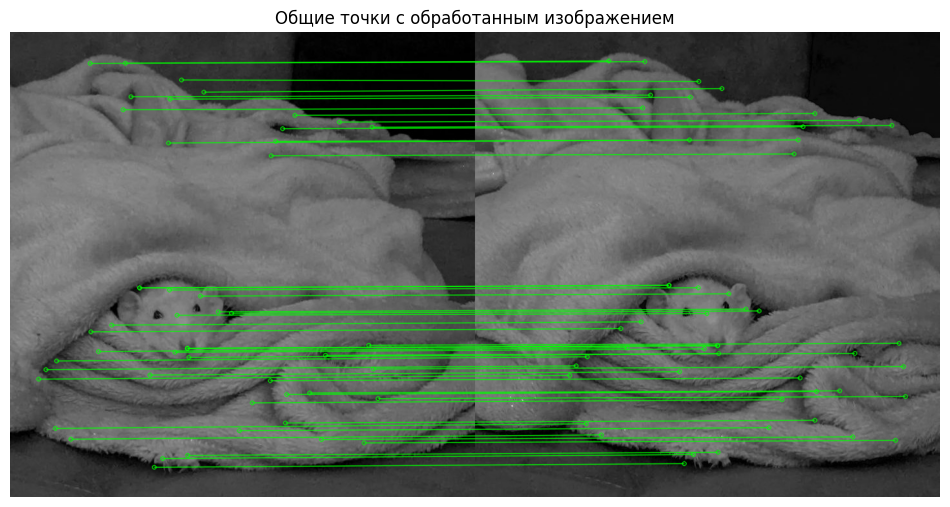

In [ ]:
# Сопоставление дескрипторов с помощью FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(filtered_descriptors_1, filtered_descriptors_2, k=2)

# Отбор хороших соответствий по тесту Лоу (Low's ratio test)
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# Вывод количества найденных соответствий
print(f"Найдено {len(good_matches)} хороших соответствий")

# Создание результирующего изображения с соответствиями
img_matches = cv2.drawMatches(
    img_1, filtered_keypoints_1,  # Первое изображение и его отфильтрованные ключевые точки
    img_2_light, filtered_keypoints_2,  # Второе изображение и его отфильтрованные ключевые точки
    good_matches,               # Хорошие соответствия
    None,                       # Результирующее изображение
    matchColor=(0, 255, 0),     # Цвет линий (зеленый)
    singlePointColor=None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# Отображение результата
plt.figure(figsize=(12, 8))
plt.title("Общие точки с обработанным изображением")
plt.imshow(img_matches, cmap='gray')
plt.axis('off')
plt.show()

Теперь сопоставим первое изображение с необработанным:

Найдено 49 хороших соответствий


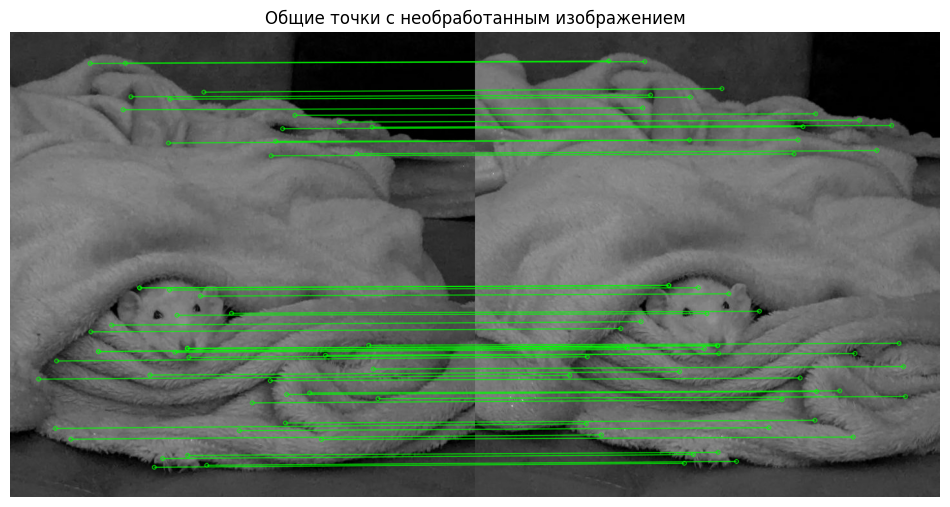

In [ ]:
# Сопоставление дескрипторов с помощью FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(filtered_descriptors_1, filtered_descriptors_old, k=2)

# Отбор хороших соответствий по тесту Лоу (Low's ratio test)
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# Вывод количества найденных соответствий
print(f"Найдено {len(good_matches)} хороших соответствий")

# Создание результирующего изображения с соответствиями
img_matches = cv2.drawMatches(
    img_1, filtered_keypoints_1,  # Первое изображение и его отфильтрованные ключевые точки
    img_2, filtered_keypoints_old,  # Второе изображение и его отфильтрованные ключевые точки
    good_matches,               # Хорошие соответствия
    None,                       # Результирующее изображение
    matchColor=(0, 255, 0),     # Цвет линий (зеленый)
    singlePointColor=None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# Отображение результата
plt.figure(figsize=(12, 8))
plt.title("Общие точки с необработанным изображением")
plt.imshow(img_matches, cmap='gray')
plt.axis('off')
plt.show()

После сопоставления первого изображения с обработанным и необработанным получим разницу всего в одну ключевую точку. При изменении значений size и response в большую и меньшую стороны - количество ключевых точек все равно не отличается больше чем на 3. Из этого можно сделать вывод, что в данной ситуации, при незначительном отклонении камеры между двумя изображениями и фотографиями, отличающимися незначительно по яркости - не обязательно регулировать яркость изображения, так как она, видимо, находится в допустимом диапазоне.

## Траектория движения камеры

По полученным ключевым точкчам построим траекторию движения камеры. Для этого необходимо определить несколько величин.  
K — внутренняя матрица камеры [3x3].
Фундаментальная матрица F — это матрица [3×3], которая также связывает соответствующие точки на двух изображениях, но в пиксельном пространстве.
Эссенциальная матрица E — это матрица [3×3], которая связывает соответствующие точки на двух изображениях, сделанных одной камерой с разных позиций. Она содержит информацию о положении и ориентации камеры между двумя кадрами.

Из эссенциальной матрицы можно получить матрицу поворота R и вектор перемещения t, которые описывают движение камеры между двумя кадрами.

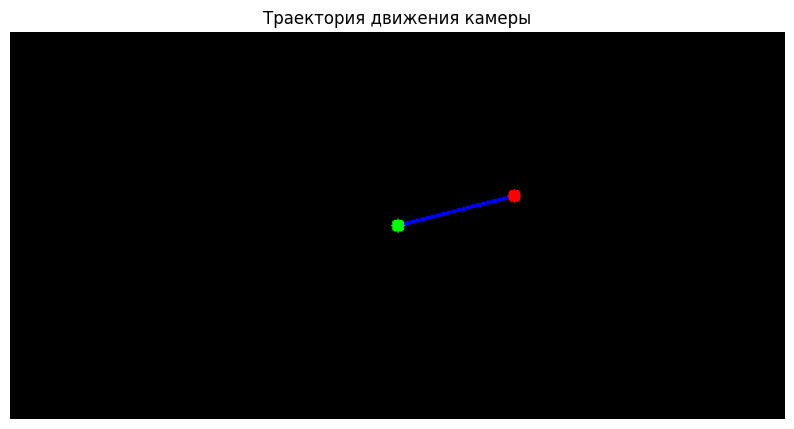

Матрица поворота (R):
[[ 0.99964627  0.00696341  0.02566796]
 [-0.00672782  0.99993455 -0.00925346]
 [-0.02573071  0.0090775   0.9996277 ]]
Вектор перемещения (t):
[[0.89483749]
 [0.36652538]
 [0.25480389]]


In [ ]:
# Получение координат ключевых точек для хороших соответствий
src_pts = np.float32([filtered_keypoints_1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([filtered_keypoints_old[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Внутренняя матрица камеры (K)
K = np.array([[1000, 0, 640], [0, 1000, 360], [0, 0, 1]])  # Примерная матрица для камеры с разрешением 1280x720 пикселей

# Нахождение фундаментальной матрицы
F, _ = cv2.findFundamentalMat(src_pts, dst_pts, cv2.FM_RANSAC)

# Находим эссенциальную матрицу
E = K.T @ F @ K

# Декомпозиция эссенциальной матрицы для получения R и t
_, R, t, _ = cv2.recoverPose(E, src_pts, dst_pts, K)

# Инициализация начального положения камеры
R_cumulative = np.eye(3)  # Начальная матрица поворота
t_cumulative = np.zeros((3, 1))  # Начальный вектор перемещения

# Обновление накопленного положения камеры
R_cumulative = R_cumulative @ R
t_cumulative += R_cumulative @ t

# Преобразование координат траектории для отображения
x, y, z = int(t_cumulative[0][0] * 100), int(t_cumulative[2][0] * 100), int(t_cumulative[1][0] * 100)
center1 = (300, 150)  # Начальная позиция камеры
center2 = (center1[0] + x, center1[1] - y)  # Конечная позиция камеры

# Построение траектории
trajectory = np.zeros((300, 600, 3), dtype=np.uint8)
cv2.line(trajectory, center1, center2, (0, 0, 255), 2)
cv2.circle(trajectory, center1, 5, (0, 255, 0), -1)  # Начальная позиция
cv2.circle(trajectory, center2, 5, (255, 0, 0), -1)  # Конечная позиция

# Отображение траектории
plt.figure(figsize=(10, 10))
plt.title("Траектория движения камеры")
plt.imshow(trajectory)
plt.axis('off')
plt.show()

# Вывод результатов
print("Матрица поворота (R):")
print(R)
print("Вектор перемещения (t):")
print(t)